In [1]:
from typing import List, Tuple, Dict, Set
import numpy as np
import pandas as pd
from Bio import SeqIO
from rapidfuzz.distance import Levenshtein
import networkx as nx
import seaborn as sns
from community import community_louvain
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
#parameter
w = 10
stepsize = 1
max_pairs = 50

In [3]:
#get subsequences with sliding window
def slide_window(x: str, w: int, step: int = 1) -> List[str]:
    if w > len(x) or w <= 0:
        return []
    starts = range(0, len(x) - w + 1, step)
    return [x[s:s + w] for s in starts]

#get Leivenshtein distance matrix among subsequences
def adist_matrix(strings: List[str]) -> np.ndarray:
    n = len(strings)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        D[i, i] = 0.0
        si = strings[i]
        for j in range(i + 1, n):
            d = Levenshtein.distance(si, strings[j])
            D[i, j] = d
            D[j, i] = d
    return D

#Jaccard index based similarity matrix
def jaccard_matrix(sets: List[Set[int]]) -> np.ndarray:
    n = len(sets)
    J = np.zeros((n, n), dtype=float)
    for i in range(n):
        si = sets[i]
        for j in range(i, n):
            sj = sets[j]
            if len(si) == 0 and len(sj) == 0:
                v = 1.0
            else:
                inter = len(si & sj)
                uni = len(si | sj)
                v = (inter / uni) if uni > 0 else 0.0
            J[i, j] = v
            J[j, i] = v
    return J


In [4]:
#example sequence
seq = "VPGLVRLTNLPHHRRPHHRRPHHRRPHHRRPHHRRPHHRRSDWVIGEHQTDAMGMPDFGEHQTDAMGMVDLEDMRKFRPHHRRPHHRRPHHRRPHHRR"

In [5]:
subseqs = slide_window(seq, w=w, step=stepsize)
n = len(subseqs)

#
D = adist_matrix(subseqs)

#
W = np.exp(-D)
np.fill_diagonal(W, 0.0)
thresh = 0.2
W_bin = np.where(W > thresh, 1.0, 0.0)
np.fill_diagonal(W_bin, 1.0)

#skip seq if it is almost diagonal W_bin
#if W_bin.sum() < (n + 10):
#    result[seqidx, 0] = 1
#    result[seqidx, 1] = 0
#    result[seqidx, 2] = ",".join(["0"] * n)
#    continue

#get features of each location
features: List[Set[int]] = []
features.append(set()) #add pseudo-node
for i in range(W_bin.shape[0]):
    idxs = np.flatnonzero(W_bin[i] == 1)

    if len(idxs) > max_pairs:
        idxs = sorted(idxs, key=lambda v: (abs(v - i), v))

    if len(idxs) < 2:
        features.append(set())
        continue

    diffs: Set[int] = set()
    for j in range(min(len(idxs)-1,max_pairs-1)):
        for k in range(j+1, min(len(idxs),max_pairs)):
            diffs.add(abs(int(idxs[j]) - int(idxs[k])))
    features.append(diffs)

#Similarity matrix with Jaccard index
A = jaccard_matrix(features)

#
thresh = 0.5
A_bin = np.where(A > thresh, 1.0, 0.0)
np.fill_diagonal(A_bin, 0.0)  # 念のため
G = nx.from_numpy_array(A_bin)  # weight=1 の無向グラフ

# Louvain 
parts = community_louvain.best_partition(G, weight="weight", random_state=0)

# label change
cid0 = parts[0]
new_parts = {}
for node, cid in parts.items():
    if cid == cid0:
        new_parts[node] = 0
    elif cid == 0:
        new_parts[node] = cid0
    else:
        new_parts[node] = cid
parts = new_parts

grp_vector = [parts.get(i, -1) for i in range(n+1)]
grp_series = pd.Series(grp_vector)
max_grp = int(grp_series.max()) if len(grp_series) else 0

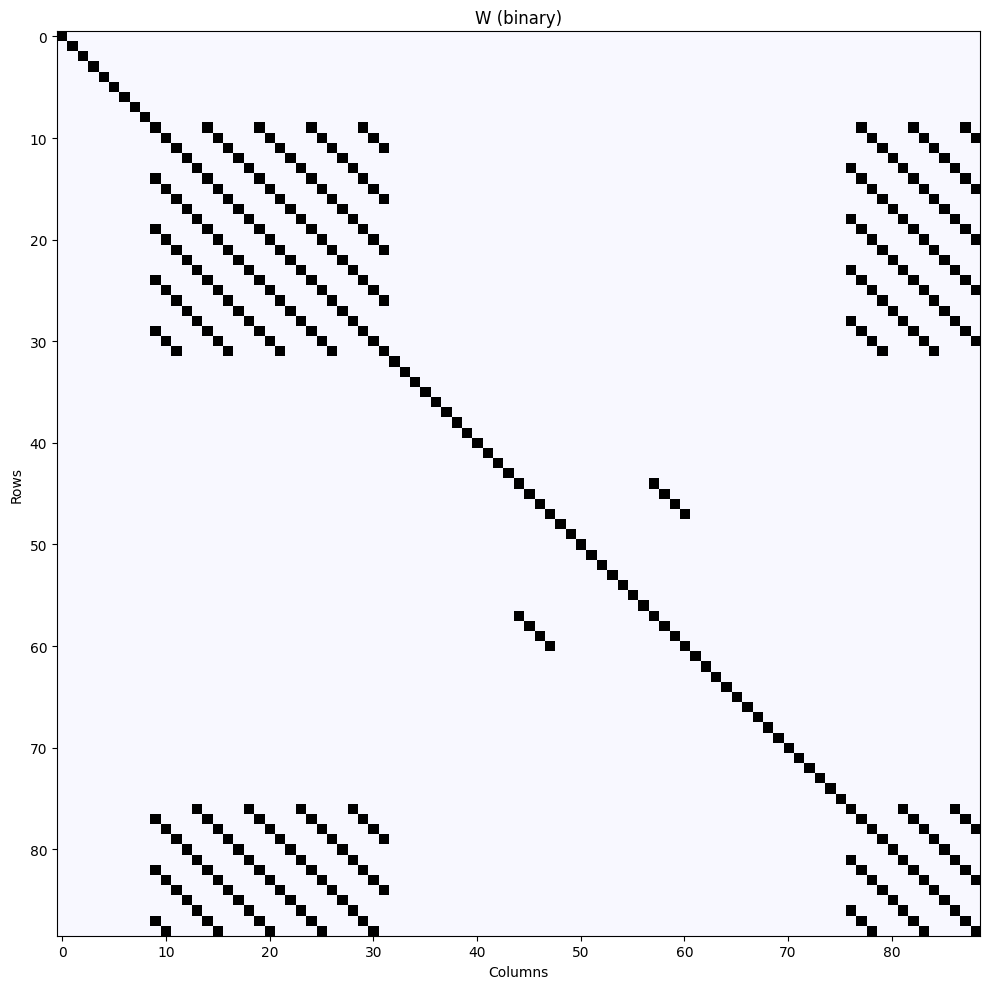

In [6]:
#visualize binary Dot-plot
cmap_bin = ListedColormap(["ghostwhite", "black"])
norm_bin = BoundaryNorm([-0.5, 0.5, 1.5], cmap_bin.N, clip=True)

plt.figure(figsize=(10, 10))
plt.imshow(W_bin, cmap=cmap_bin, norm=norm_bin, aspect="auto", interpolation="nearest")
plt.title(f"W (binary)")
plt.xlabel("Columns")
plt.ylabel("Rows")

plt.tight_layout()
plt.show()

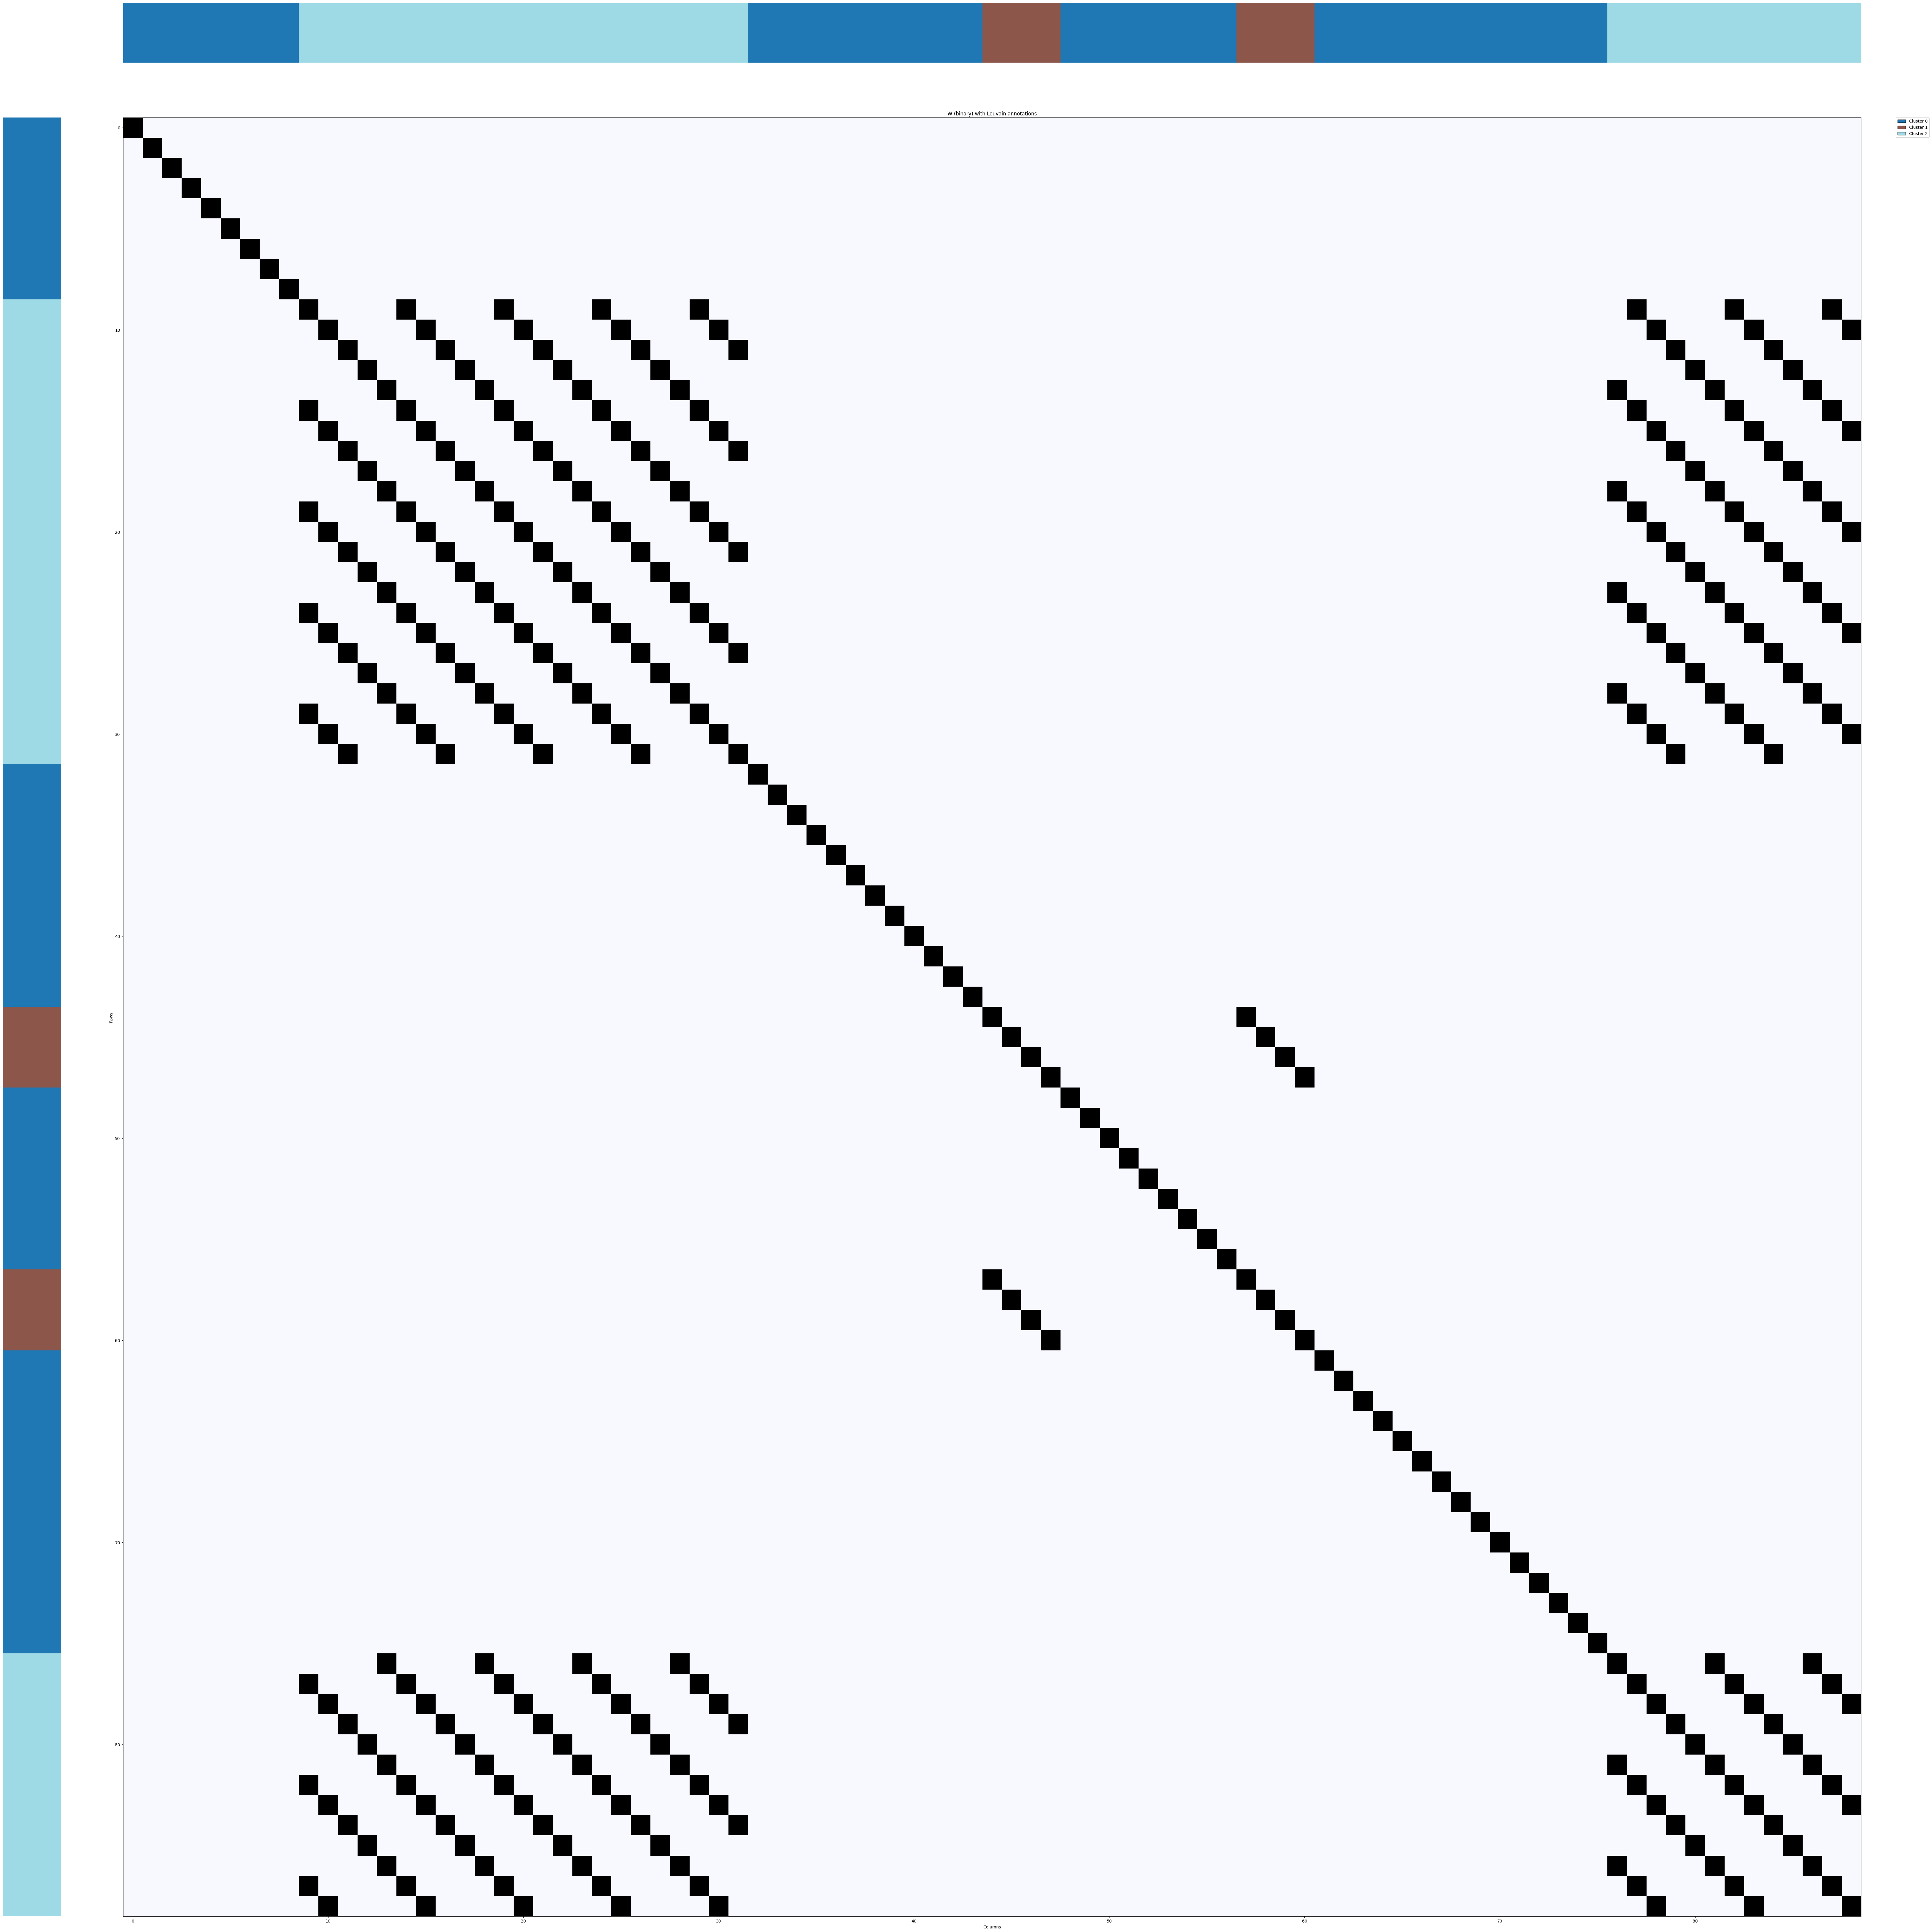

In [ ]:
# Re-plot W with annotations (to display cluster IDs for rows and columns)
# pheatmap-like annotation_row/annotation_col display: draw color bars on the top (columns) and left (rows)
unique_grps = np.unique(grp_vector)

# Assign colors to each group
cmap_bar = plt.get_cmap('tab20', len(unique_grps))
color_map = {g: cmap_bar(i) for i, g in enumerate(unique_grps)}
row_colors = np.array([color_map[g] for g in grp_vector[1:]])
col_colors = row_colors  # 対称なので同じ注釈を使う

cmap_bin = ListedColormap(["ghostwhite", "black"])
norm_bin = BoundaryNorm([-0.5, 0.5, 1.5], cmap_bin.N, clip=True)

fig = plt.figure(figsize=(65, 65), constrained_layout=True)
# Layout: column annotation bar on top, row annotation bar on the left, main heatmap in the center
gs = fig.add_gridspec(2, 2, width_ratios=(0.1, 3.0), height_ratios=(0.1, 3.0),
                        wspace=0.05, hspace=0.05)

ax_col = fig.add_subplot(gs[0, 1])
ax_row = fig.add_subplot(gs[1, 0])
ax_main = fig.add_subplot(gs[1, 1])

# Column annotation bar
ax_col.imshow(col_colors[np.newaxis, :, :], aspect="auto")
ax_col.set_axis_off()

# Row annotation bar
ax_row.imshow(row_colors[:, np.newaxis, :], aspect="auto")
ax_row.set_axis_off()

# Main heatmap
im = ax_main.imshow(W_bin, cmap=cmap_bin, norm=norm_bin, aspect="auto", interpolation="nearest")
ax_main.set_title(f"W (binary) with Louvain annotations")
ax_main.set_xlabel("Columns")
ax_main.set_ylabel("Rows")

# Legend (groups)
from matplotlib.patches import Patch
handles = [Patch(facecolor=color_map[g], edgecolor='k', label=f"Cluster {g}") for g in unique_grps]
ax_main.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)